# Lab 1

## Goal
Given the well known _iris_ dataset, find a ML-based way to tell which is the hardest variable to be predicted, given the other variables, and motivate the answer.

## Setting the environment

In [38]:
# Very important imports

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

## Data exploration 

In [39]:
# Load the data as a pandas dataframe with 5 variables

iris = load_iris(as_frame=True)
df = iris["data"]
df["species"] = iris["target"]

In [40]:
# Retrieve useful information about the dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   species            150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


In [41]:
# Print first rows of the dataframe

df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


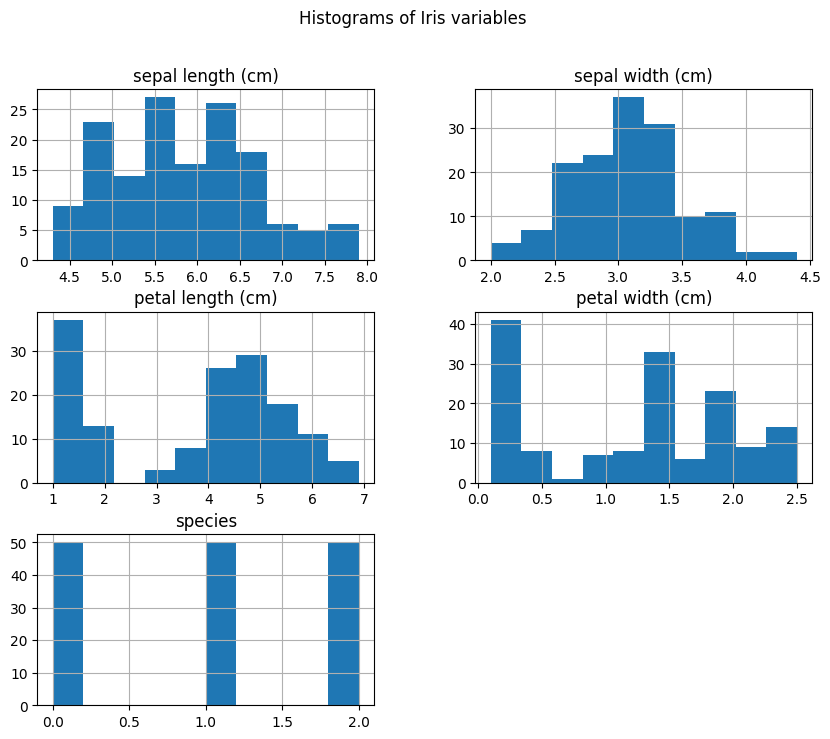

In [42]:
# Basic exploratory analysis to observe the distribution of the variables

df.hist(figsize=(10, 8))
plt.suptitle("Histograms of Iris variables")
plt.show()

## Naive solution

Let us fit a decision tree for each possible choice of the response variable among the five variables of the dataframe. The model which will achieve the highest error on k-fold cross validations is dealing with the variable that is hardest to predict.

In [43]:
for variable in df.columns:
    X, y = df.drop(columns=[variable]), df[variable]
    
    if variable != "species":
        tree = DecisionTreeRegressor(random_state=314,
                                     criterion="squared_error",
                                     max_depth=3,
                                     min_samples_split=10)
        metric = "neg_mean_squared_error"

    else:
        tree = DecisionTreeClassifier(random_state=314,
                                      criterion="gini",
                                      max_depth=3,
                                      min_samples_split=10)
        metric = "accuracy"
    
    # Perform k-fold cross validation to get scores (MSE or accuracy according to the kind of tree)
    scores = cross_val_score(tree, X, y, cv = 5, scoring=metric)
    
    print(f"Model with response variable {variable} achieved {metric} of {scores.mean():.2f} \n")

Model with response variable sepal length (cm) achieved neg_mean_squared_error of -0.17 

Model with response variable sepal width (cm) achieved neg_mean_squared_error of -0.09 

Model with response variable petal length (cm) achieved neg_mean_squared_error of -0.14 

Model with response variable petal width (cm) achieved neg_mean_squared_error of -0.04 

Model with response variable species achieved accuracy of 0.97 



Is it better an accuracy of $0.97$ or a mean squared error of $0.04$? We can see that this approach does not yield a reasonable response: we are comparing metrics which measure different types of error. 

However, we can assert that a zero error is an excellent performance, whether it's represented by an accuracy of $1$ or a mean squared error of $0$. Let's think about it...

## Second solution
Since the problem is that we cannot compare the absolute values of the error, one possibility is to consider the complexity a model exhibits for obtaining an error of $0$. The rationale is that $0$ is comparable with $0$, since they both represent the absence of any error, regardless of the scale. We need hence a way for measuring the complexity: for trees, this is easy, since we can simply count the number of nodes.

We remove the constraints on the complexity of the fitted tree. Each fitted train will achieve perfect results. Please note that, we are not using K-fold CV.


In [44]:
for variable in df.columns:
    
    X, y = df.drop(columns=[variable]), df[variable]
    
    if variable != "species":
        tree = DecisionTreeRegressor(random_state=314,
                                     criterion="squared_error")

    else:
        tree = DecisionTreeClassifier(random_state=314,
                                      criterion="gini")
    
    # Fit the model
    tree.fit(X,y)
    
    print(f"Model with response variable {variable} requires {tree.tree_.node_count} nodes to reach zero error.\n")

Model with response variable sepal length (cm) requires 261 nodes to reach zero error.

Model with response variable sepal width (cm) requires 263 nodes to reach zero error.

Model with response variable petal length (cm) requires 267 nodes to reach zero error.

Model with response variable petal width (cm) requires 221 nodes to reach zero error.

Model with response variable species requires 17 nodes to reach zero error.



Based on this observation, achieving perfect regression requires more nodes than achieving perfect classification. This suggests that classification could be inherently easier than regression.

In conclusion, we write a complete procedure for solving the exercise according to the complexity method.

In [45]:
def hardest_to_predict(df, categorical_variable="species"):
    hardest_variable = None
    max_nodes = -1

    for variable in df.columns:
        X, y = df.drop(columns=[variable]), df[variable]
        
        if variable != categorical_variable:
            tree = DecisionTreeRegressor(random_state=314, criterion="squared_error")
        else:
            tree = DecisionTreeClassifier(random_state=314, criterion="gini")
        
        # Fit the tree model
        tree.fit(X, y)
        
        # Get the number of nodes in the tree
        node_count = tree.tree_.node_count
                
        # Update hardest variable if this tree has more nodes
        if node_count > max_nodes:
            max_nodes = node_count
            hardest_variable = variable

    # Return the hardest variable and its node count
    return hardest_variable, max_nodes

In [46]:
hardest_variable, max_nodes = hardest_to_predict(df)
print("The hardest variable to predict is", hardest_variable, "which requires", max_nodes, "nodes.")

The hardest variable to predict is petal length (cm) which requires 267 nodes.
